In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from velosafe.models import grid_search, stratified_sample, save_model

## Data loading

In [2]:
df = pd.read_csv("../data/training_data.csv")

## Data preprocessing

### Filter features

In [3]:
FEATURES = [
    "population",
    "area",
    "accident_num",
    "length",
    "ACCOTEMENT REVETU HORS CVCB",
    "AMENAGEMENT MIXTES PIETON VELO HORS VOIE VERTE",
    "AUTRE",
    "BANDE CYCLABLE",
    "CHAUSSEE A VOIE CENTRALE BANALISEE",
    "COULOIR BUS+VELO",
    "DOUBLE SENS CYCLABLE BANDE",
    "DOUBLE SENS CYCLABLE NON MATERIALISE",
    "DOUBLE SENS CYCLABLE PISTE",
    "GOULOTTE",
    "PISTE CYCLABLE",
    "VELO RUE",
    "VOIE VERTE",
]

df = df[FEATURES]
df.head()

,population,area,accident_num,length,ACCOTEMENT REVETU HORS CVCB,AMENAGEMENT MIXTES PIETON VELO HORS VOIE VERTE,AUTRE,BANDE CYCLABLE,CHAUSSEE A VOIE CENTRALE BANALISEE,COULOIR BUS+VELO,DOUBLE SENS CYCLABLE BANDE,DOUBLE SENS CYCLABLE NON MATERIALISE,DOUBLE SENS CYCLABLE PISTE,GOULOTTE,PISTE CYCLABLE,VELO RUE,VOIE VERTE
0,234,1355,0.0,1625.607995,0.0,1625.607995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,375,1654,0.0,41750.307169,0.0,0.000000,41750.307169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,1242,2334,0.0,20727.046260,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19289.721231,1437.325029,0.0
3,1318,3016,0.0,70.520285,0.0,0.000000,70.520285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,319,1022,0.0,4816.411348,0.0,4816.411348,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


### Train/test split

In [4]:
df_train, df_test = stratified_sample(df, 0.15)

In [5]:
X_train, y_train = df_train[df_train.columns.difference(["accident_num"])], df_train["accident_num"].values
X_test, y_test = df_test[df_test.columns.difference(["accident_num"])], df_test["accident_num"].values

## Model selection

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [7]:
linear_model, linear_perf = grid_search(
    LinearRegression(), {"fit_intercept": [True, False]}, X_train, y_train, scaler=StandardScaler()
)
linear_perf

,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,{'fit_intercept': True},-2.167513,0.466865,-1.914076,0.088352
1,{'fit_intercept': False},-2.201164,0.452614,-1.950693,0.089598


In [17]:
random_forest_model, random_forest_perf = grid_search(
    RandomForestRegressor(),
    {"n_estimators": [100, 200, 500], "max_depth": [None, 20]},
    X_train,
    y_train,
    scaler=StandardScaler(),
)
random_forest_perf

## Model evaluation

In [12]:
best_model = random_forest_model

In [13]:
mean_squared_error(y_test, best_model.predict(X_test))

1.2718304841136654

(-1.0, 15.0)

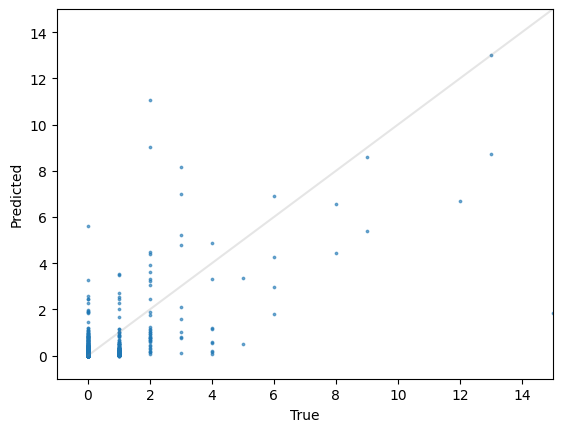

In [14]:
plt.plot(y_test, y_test, color="gray", alpha=0.2)
plt.scatter(y_test, best_model.predict(X_test), s=3, alpha=0.6)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.xlim(-1, 15)
plt.ylim(-1, 15)